![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

This project seeks to build machine learning models to achieve two things:

1. Predict the highest ranking a song will achieve on the Billboard Hot 100 list.
2. Predict the largest week over week increase in a given song's ranking on the Hot 100 list.

Key Insights:

- A song's genre has a minimal impact on its ranking on the Billboard Hot 100 list.
- Song characteristics such as tempo, danceability, etc. appear to be the strongest drivers of their performance on the Hot 100 list.
- Analyzing music can quickly lead to an overwhelming number of features, so thoughtful and careful data selection is key.

## Business Understanding

The customer of this project is FutureProduct Advisors, a consultancy that helps their customers develop innovative and new consumer products. FutureProduct’s customers are increasingly seeking help from their consultants in go-to-market activities. 

FutureProduct’s consultants can support these go-to-market activities, but the business does not have all the infrastructure needed to support it. Their biggest ask is for a tool to help them find interesting, up-and-coming music to accompany social posts and online ads for go-to-market promotions. 

**Stakeholders**

- FutureProduct Managing Director: oversees their consulting practice and is sponsoring this project.
- FutureProduct Senior Consultants: the actual users of the prospective tool. A small subset of the consultants will pilot the prototype tool.
- My consulting leadership: sponsors of this effort; will provide oversight and technical input of the project as needed.

**Primary Goals**

1.	Build a data tool that can evaluate any song in the Billboard Hot 100 list and make predictions about:
    -	The song’s position on the Hot 100 list 4 weeks in the future
    -	The song’s highest position on the list in the next 6 months
2.	Create a rubric that lists the 3 most important factors for songs’ placement on the Hot 100 list for each hear from 2000 to 2021.


## Data Understanding

Billboard Hot 100 weekly charts (Kaggle): https://www.kaggle.com/datasets/thedevastator/billboard-hot-100-audio-features

I’ve chosen this dataset because it has a direct measurement of song popularity (the Hot 100 list) and because its long history gives significant context to a song’s positioning in a given week.
The features list gives a wide range of song attributes to explore and enables me to determine what features most significantly contribute to a song’s popularity and how that changes over time.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ast
from collections import Counter

import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mean_squared_error, r2_score, pairwise_distances

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(42)

In [3]:
df_hotlist_all = pd.read_csv('Data/Hot Stuff.csv')
df_features_all = pd.read_csv('Data/Hot 100 Audio Features.csv')

In [ ]:
# exploring hotlist df
df_hotlist_all.info()

In [ ]:
# exploring features df
df_features_all.info()

#### Exploratory Data Analysis

Mean Highest Ranking: 76


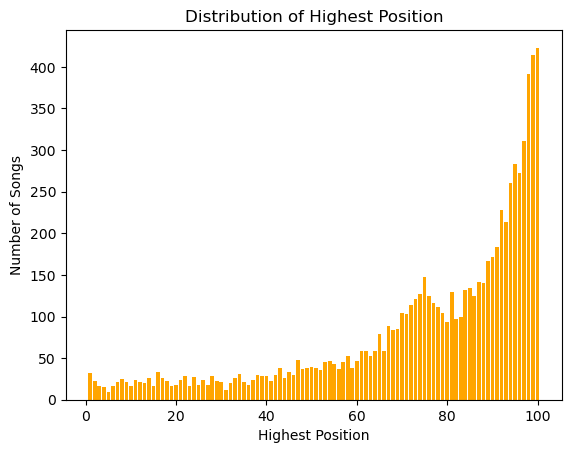

In [109]:
peak_pos_dist = df_clean_withgenre['Max_Peak_Position'].value_counts()
df_peak_pos_dist = pd.DataFrame(peak_pos_dist)
df_peak_pos_dist = df_peak_pos_dist.reset_index()
print(f"Mean Highest Ranking: {df_clean_withgenre['Max_Peak_Position'].mean():.0f}")

plt.bar(df_peak_pos_dist['Max_Peak_Position'], df_peak_pos_dist['count'], color='orange')
plt.xlabel('Highest Position')
plt.ylabel('Number of Songs')
plt.title('Distribution of Highest Position')
plt.show()

Mean Largest Week over Week Rank Change: 13


Text(0.5, 1.0, 'Frequency of Largest Week over Week Rank Change')

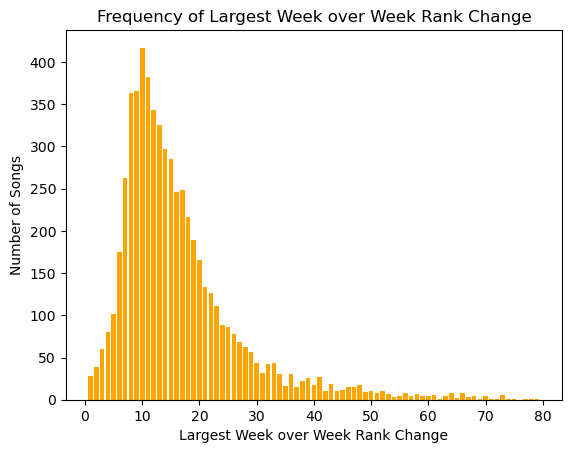

In [110]:
max_rank_change = df_clean_withgenre['Max_Rank_Change'].value_counts()
df_max_rank_change = pd.DataFrame(max_rank_change)
df_max_rank_change = df_max_rank_change.reset_index()
df_max_rank_change = df_max_rank_change[df_max_rank_change['Max_Rank_Change'] > 0]
print(f"Mean Largest Week over Week Rank Change: {df_clean_withgenre['Max_Rank_Change'].mean():.0f}")

plt.bar(df_max_rank_change['Max_Rank_Change'], df_max_rank_change['count'], color='orange')
plt.xlabel('Largest Week over Week Rank Change')
plt.ylabel('Number of Songs')
plt.title('Frequency of Largest Week over Week Rank Change')


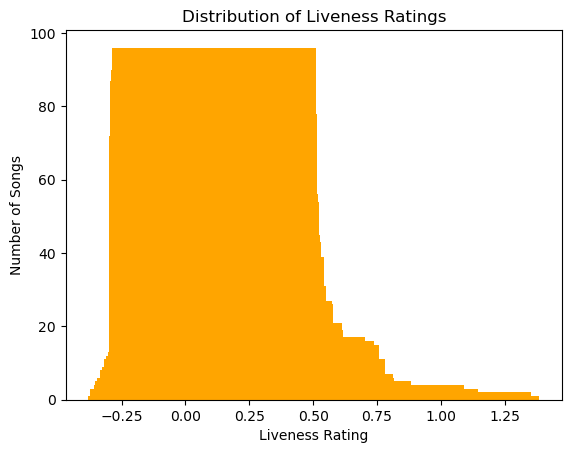

In [100]:
liveness_dist = df_clean_withgenre['liveness'].value_counts()
df_liveness_dist = pd.DataFrame(liveness_dist)
df_liveness_dist = df_liveness_dist.reset_index()

plt.bar(df_liveness_dist['liveness'], df_liveness_dist['count'], color='orange')
plt.xlabel('Liveness Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Liveness Ratings')
plt.show()

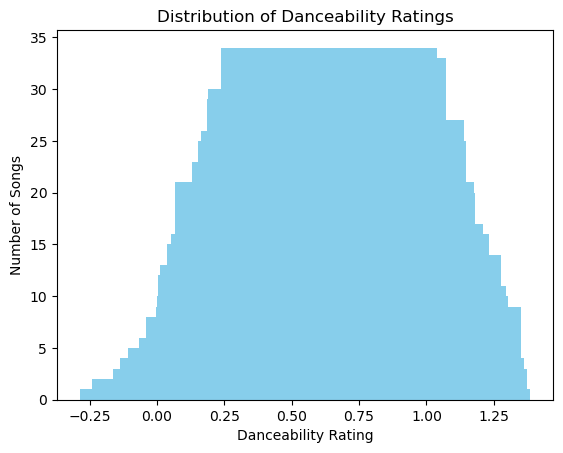

In [101]:
danceability_dist = df_clean_withgenre['danceability'].value_counts()
df_danceability_dist = pd.DataFrame(danceability_dist)
df_danceability_dist = df_danceability_dist.reset_index()

plt.bar(df_danceability_dist['danceability'], df_danceability_dist['count'], color='skyblue')
plt.xlabel('Danceability Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Danceability Ratings')
plt.show()

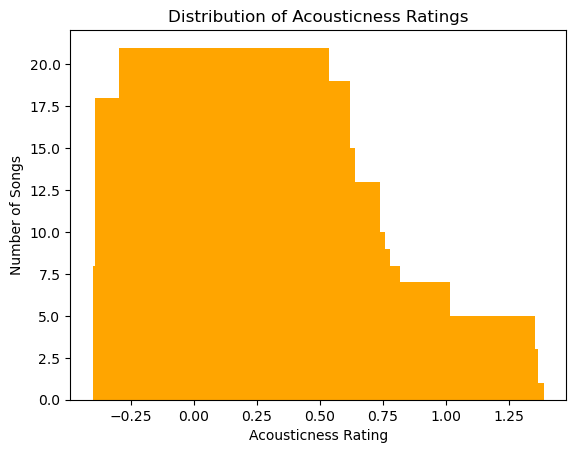

In [102]:
acousticness_dist = df_clean_withgenre['acousticness'].value_counts()
df_acousticness_dist = pd.DataFrame(acousticness_dist)
df_acousticness_dist = df_acousticness_dist.reset_index()

plt.bar(df_acousticness_dist['acousticness'], df_acousticness_dist['count'], color='orange')
plt.xlabel('Acousticness Rating')
plt.ylabel('Number of Songs')
plt.title('Distribution of Acousticness Ratings')
plt.show()

Text(0.5, 1.0, 'Frequency of Peak Rankings')

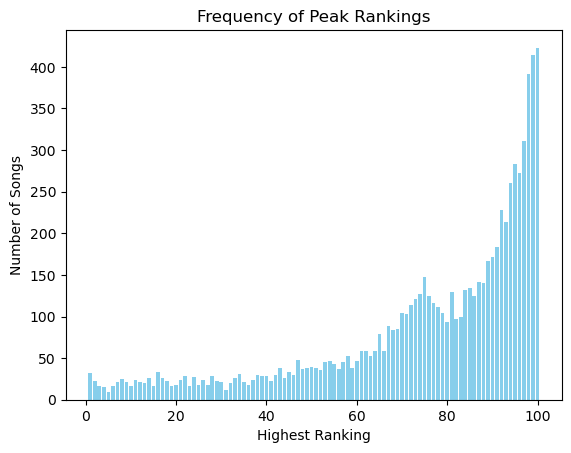

In [104]:
plt.bar(df_peak_pos_dist['Max_Peak_Position'], df_peak_pos_dist['count'], color='skyblue')
plt.xlabel('Highest Ranking')
plt.ylabel('Number of Songs')
plt.title('Frequency of Peak Rankings')

## Data Preparation

### Initial Data Selection

In [4]:
# removing hotlist df attributes that will not be used in cleaning or analysis
df_hotlist_all = df_hotlist_all.drop(['index', 'url', 'Song', 'Performer', 'Instance'], axis=1)
# converting WeekID to datetime
df_hotlist_all['WeekID'] = pd.to_datetime(df_hotlist_all['WeekID'], errors='coerce')
df_hotlist_all = df_hotlist_all.sort_values(by='WeekID')

# creating a new hotlist df with only complete year data from 2000 - 2020, the time period being studied
df_hotlist_2000s = df_hotlist_all.loc[(df_hotlist_all['WeekID'] > '1999-12-31') & (df_hotlist_all['WeekID'] < '2021-01-01')]

# adding a column to calculate the week over week change in rank
def diff(a, b):
    return a - b

df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s.apply(lambda x: diff(x['Week Position'], x['Previous Week Position']), axis=1)
# replacing NaNs with 0
df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s['Rank_Change'].fillna(0)

# removing features df attributes that will not be used in cleaning or analysis
df_features_all = df_features_all.drop(['index', 'Performer', 'Song', 'spotify_track_album', 
                                        'spotify_track_id', 'spotify_track_preview_url',  
                                        'spotify_track_explicit', 'spotify_track_popularity'], axis=1)


C:\Users\marha\AppData\Local\Temp\ipykernel_18008\3177740419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s.apply(lambda x: diff(x['Week Position'], x['Previous Week Position']), axis=1)
C:\Users\marha\AppData\Local\Temp\ipykernel_18008\3177740419.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hotlist_2000s['Rank_Change'] = df_hotlist_2000s['Rank_Change'].fillna(0)


In [5]:
# combining the hotlist and features into one dataframe

df_hotlist_and_features_2000s = pd.merge(df_hotlist_2000s, df_features_all, on='SongID', how='left')
df_hotlist_and_features_2000s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112098 entries, 0 to 112097
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   WeekID                     112098 non-null  datetime64[ns]
 1   Week Position              112098 non-null  int64         
 2   SongID                     112098 non-null  object        
 3   Previous Week Position     101571 non-null  float64       
 4   Peak Position              112098 non-null  int64         
 5   Weeks on Chart             112098 non-null  int64         
 6   Rank_Change                112098 non-null  float64       
 7   spotify_genre              108091 non-null  object        
 8   spotify_track_duration_ms  104590 non-null  float64       
 9   danceability               104287 non-null  float64       
 10  energy                     104287 non-null  float64       
 11  key                        104287 non-null  float64 

### Feature Engineering

In [6]:
"""
The dataset has genre in a single column and the entry for each song has a variety of genres listed in that single column. 
This does not allow me to explore genre in a systematic way.
I'll need to break genre out so that each genre has its own column with a 1 or 0 to indicate whether each song is tagged with that genre 
(ending with a one-hot encoded structure).
"""

# generating a df with unique genre names
unique_genres = list(set(
    genre 
    for genre_string in df_hotlist_and_features_2000s['spotify_genre'] 
    if pd.notna(genre_string)
    for genre in ast.literal_eval(genre_string)
))

df_unique_genres = pd.DataFrame(unique_genres, columns=['genre'])

# adding counts of each unique genre name
# Extract all genres (with duplicates) and count them
all_genres_list = []
for genre_string in df_hotlist_and_features_2000s['spotify_genre']:
    if pd.notna(genre_string):
        genre_list = ast.literal_eval(genre_string)
        all_genres_list.extend(genre_list)

# Count occurrences
genre_counts = Counter(all_genres_list)

# Map counts to genres dataframe
df_unique_genres['count'] = df_unique_genres['genre'].map(genre_counts)
df_unique_genres = df_unique_genres.sort_values('count', ascending=False)

In [ ]:
# writing to csv for easier review of the data
df_unique_genres.to_csv('genre_counts.csv', index=False)

After reviewing the full set of genre counts, I'm only including genres that appear in 100 or more songs (i.e. at least 0.1% of songs).

In [7]:
# loading list of genres with 100 or more instances in df_cleaned
df_genres_100_up = pd.read_csv('genre_counts_100+inst.csv')

# converting df to list
final_genres_list = df_genres_100_up['genre'].tolist()

# manually one-hot encoding each genre

# creating a list of genres and counts
genre_data = []

for genre_string in df_hotlist_and_features_2000s['spotify_genre'] :
    if pd.notna(genre_string):
        genre_list = ast.literal_eval(genre_string)
        row_dict = {genre: (1 if genre in genre_list else 0) for genre in final_genres_list} # dict with 1 if genre exists in list, 0 if not
    else:
         row_dict = {genre: 0 for genre in final_genres_list} # 0 of genre does not exist in list
    genre_data.append(row_dict)

# creating a df with the list of dicts
genre_df = pd.DataFrame(genre_data)

# concatenating genre data into df_clean
df_hotlist_and_features_2000s = pd.concat([df_hotlist_and_features_2000s, genre_df], axis=1)


In [8]:
# removing spotify_genre and spot-checking resulting df 
pd.set_option('display.max_columns', None)
df_hotlist_and_features_2000s = df_hotlist_and_features_2000s.drop(['spotify_genre'], axis=1)
df_hotlist_and_features_2000s.head()

,WeekID,Week Position,SongID,Previous Week Position,Peak Position,Weeks on Chart,Rank_Change,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pop,dance pop,pop rap,rap,contemporary country,country,country road,post-teen pop,hip hop,r&b,urban contemporary,trap,southern hip hop,pop rock,hip pop,modern country rock,neo mellow,post-grunge,gangster rap,atl hip hop,alternative metal,neo soul,dirty south rap,country dawn,modern rock,nu metal,canadian pop,rock,melodic rap,deep pop r&b,edm,new jack swing,permanent wave,miami hip hop,country pop,oklahoma country,latin,tropical house,electropop,uk pop,east coast hip hop,alternative rock,viral pop,quiet storm,chicago rap,redneck,pop punk,crunk,country rock,toronto rap,canadian hip hop,boy band,hardcore hip hop,queens hip hop,talent show,emo,europop,acoustic pop,alternative r&b,conscious hip hop,australian pop,detroit hip hop,rap rock,latin pop,barbadian pop,g funk,girl group,canadian rock,tropical,piano rock,indie pop,electro house,indie poptimism,rap metal,west coast rap,new orleans rap,metropopolis,candy pop,lilith,australian country,philly rap,funk metal,reggaeton,dfw rap,canadian contemporary r&b,soul,mexican pop,adult standards,nc hip hop,british soul,trap queen,hollywood,arkansas country,atl trap,underground hip hop,texas country,uk dance,house,new wave pop,brostep,dancehall,progressive house,funk,singer-songwriter,latin hip hop,idol,garage rock,mellow gold,baroque pop,big room,art pop,reggae fusion,cali rap,bronx hip hop,folk-pop,country rap,stomp and holler,neon pop punk,emo rap,punk,indie rock,funk rock,memphis hip hop,modern alternative rock,lgbtq+ hip hop,progressive electro house,alternative hip hop,blues rock,colombian pop,eurodance,classic rock,baton rouge rap,australian dance,folk,pop emo,soft rock,motown,pixie,canadian country,wrestling,glee club,complextro,vapor trap,etherpop,pittsburgh rap,escape room,indietronica,comic,german techno,new jersey rap,trap latino,houston rap,social media pop,puerto rican pop,deep southern trap,heartland rock,alternative dance,bubblegum dance,alberta country,outlaw country,country gospel,florida rap,hard rock,canadian metal,christian rock,soca,indiecoustica,harlem hip hop,new rave,electronic trap,christian music,grunge,show tunes,viral trap,la indie,swedish pop,swedish electropop,reggaeton flow,dance-punk,celtic rock,socal pop punk,lounge,chicano rap,stomp pop,ccm,vocal jazz,glam metal,worship,irish rock,electropowerpop,electro,indie pop rap,canadian contemporary country,bounce,christian alternative rock,south african rock,deep talent show,disco,hyphy,disco house,canadian latin,australian hip hop,nyc rap,brill building pop,k-pop,nz pop,minnesota hip hop,modern blues rock,album rock,modern folk rock,uk americana,old school hip hop,punk blues,dmv rap,industrial metal,skate punk,swedish synthpop,moombahton
0,2000-01-01,69,Deck The HallsSHeDAISY,97.0,69,2,-28.0,229773.0,0.575,0.837,1.0,-7.141,0.0,0.0406,0.0195,0.000009,0.144,0.444,118.827,4.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2000-01-01,83,Guerrilla RadioRage Against The Machine,87.0,69,10,-4.0,206200.0,0.599,0.957,11.0,-5.764,1.0,0.1880,0.0129,0.000071,0.155,0.489,103.680,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [9]:
# creating new df with most 5 most popular genres by week

# Get all genre column names
genre_start_idx = df_hotlist_and_features_2000s.columns.get_loc('pop')
genre_cols = df_hotlist_and_features_2000s.columns[genre_start_idx:].tolist()

# Group by WeekID and sum the genre columns to get counts
genre_counts = df_hotlist_and_features_2000s.groupby('WeekID')[genre_cols].sum()

# For each week, find the top 5 genres
top_genres = []
for week_id in genre_counts.index:
    # Get the genre counts for this week and sort them
    week_genres = genre_counts.loc[week_id].sort_values(ascending=False)
    
    # Get the top 3 genre names
    top_5 = week_genres.head(5).index.tolist()
    
    # Pad with None if there are fewer than 5 genres
    while len(top_5) < 5:
        top_5.append(None)
    
    top_genres.append({
        'WeekID': week_id,
        'Most_Popular_Genre': top_5[0],
        '2nd_Most_Popular_Genre': top_5[1],
        '3rd_Most_Popular_Genre': top_5[2],
        '4th_Most_Popular_Genre': top_5[3],
        '5th_Most_Popular_Genre': top_5[4]
    })

# Create the new dataframe
df_top_genres = pd.DataFrame(top_genres)


In [10]:
# adding a column to the main df indicating whether each song is in a genre that's in the top 5 genres for a given week

def is_in_top5_genres(row, df_top_genres):
    week = row['WeekID']

    top_genres = df_top_genres[df_top_genres['WeekID'] == week]

    if len(top_genres) == 0:
        return 0
    
    top_5 = [
        top_genres.iloc[0]['Most_Popular_Genre'],
        top_genres.iloc[0]['2nd_Most_Popular_Genre'],
        top_genres.iloc[0]['3rd_Most_Popular_Genre'],
        top_genres.iloc[0]['4th_Most_Popular_Genre'],
        top_genres.iloc[0]['5th_Most_Popular_Genre'],
        ]

    for genre in top_5:
        if genre in row.index and row[genre] == 1:
            return 1
        
        else:
            return 0
        
df_hotlist_and_features_2000s['in_top5_genres'] = df_hotlist_and_features_2000s.apply(
    lambda row: is_in_top5_genres(row, df_top_genres), axis=1
)

In [11]:
# new df with mean score of appearance in top 5 weekly genres
df_mean_genre_match = df_hotlist_and_features_2000s.groupby('SongID', as_index=False)['in_top5_genres'].mean()
df_mean_genre_match.rename(columns={'in_top5_genres': 'In_Top5genres_Mean'}, inplace=True)
df_mean_genre_match.set_index('SongID', inplace=True)

# new df with the max weekly rank change for each song 
df_max_rank_change = df_hotlist_and_features_2000s.groupby('SongID', as_index=False)['Rank_Change'].max()
df_max_rank_change.rename(columns={'Rank_Change': 'Max_Rank_Change'}, inplace=True)
df_max_rank_change.set_index('SongID', inplace=True)

# new df with the max peak rank for each song 
df_max_peak_pos = df_hotlist_and_features_2000s.groupby('SongID', as_index=False)['Peak Position'].max()
df_max_peak_pos.rename(columns={'Peak Position': 'Max_Peak_Position'}, inplace=True)
df_max_peak_pos.set_index('SongID', inplace=True)

# ensuring these new dfs have no null values
df_max_rank_change['Max_Rank_Change'].isna().sum(), df_max_peak_pos['Max_Peak_Position'].isna().sum(), df_mean_genre_match['In_Top5genres_Mean'].isna().sum()

(0, 0, 0)

In [12]:
# adding max peak position to main df
df_2000s_data = df_hotlist_and_features_2000s.join(df_max_peak_pos, on='SongID')

# adding max rank change to main df
df_2000s_data = df_2000s_data.join(df_max_rank_change, on='SongID')

# adding in top5genres mean to main df
df_2000s_data = df_2000s_data.join(df_mean_genre_match, on='SongID')

df_2000s_data.head()

,WeekID,Week Position,SongID,Previous Week Position,Peak Position,Weeks on Chart,Rank_Change,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pop,dance pop,pop rap,rap,contemporary country,country,country road,post-teen pop,hip hop,r&b,urban contemporary,trap,southern hip hop,pop rock,hip pop,modern country rock,neo mellow,post-grunge,gangster rap,atl hip hop,alternative metal,neo soul,dirty south rap,country dawn,modern rock,nu metal,canadian pop,rock,melodic rap,deep pop r&b,edm,new jack swing,permanent wave,miami hip hop,country pop,oklahoma country,latin,tropical house,electropop,uk pop,east coast hip hop,alternative rock,viral pop,quiet storm,chicago rap,redneck,pop punk,crunk,country rock,toronto rap,canadian hip hop,boy band,hardcore hip hop,queens hip hop,talent show,emo,europop,acoustic pop,alternative r&b,conscious hip hop,australian pop,detroit hip hop,rap rock,latin pop,barbadian pop,g funk,girl group,canadian rock,tropical,piano rock,indie pop,electro house,indie poptimism,rap metal,west coast rap,new orleans rap,metropopolis,candy pop,lilith,australian country,philly rap,funk metal,reggaeton,dfw rap,canadian contemporary r&b,soul,mexican pop,adult standards,nc hip hop,british soul,trap queen,hollywood,arkansas country,atl trap,underground hip hop,texas country,uk dance,house,new wave pop,brostep,dancehall,progressive house,funk,singer-songwriter,latin hip hop,idol,garage rock,mellow gold,baroque pop,big room,art pop,reggae fusion,cali rap,bronx hip hop,folk-pop,country rap,stomp and holler,neon pop punk,emo rap,punk,indie rock,funk rock,memphis hip hop,modern alternative rock,lgbtq+ hip hop,progressive electro house,alternative hip hop,blues rock,colombian pop,eurodance,classic rock,baton rouge rap,australian dance,folk,pop emo,soft rock,motown,pixie,canadian country,wrestling,glee club,complextro,vapor trap,etherpop,pittsburgh rap,escape room,indietronica,comic,german techno,new jersey rap,trap latino,houston rap,social media pop,puerto rican pop,deep southern trap,heartland rock,alternative dance,bubblegum dance,alberta country,outlaw country,country gospel,florida rap,hard rock,canadian metal,christian rock,soca,indiecoustica,harlem hip hop,new rave,electronic trap,christian music,grunge,show tunes,viral trap,la indie,swedish pop,swedish electropop,reggaeton flow,dance-punk,celtic rock,socal pop punk,lounge,chicano rap,stomp pop,ccm,vocal jazz,glam metal,worship,irish rock,electropowerpop,electro,indie pop rap,canadian contemporary country,bounce,christian alternative rock,south african rock,deep talent show,disco,hyphy,disco house,canadian latin,australian hip hop,nyc rap,brill building pop,k-pop,nz pop,minnesota hip hop,modern blues rock,album rock,modern folk rock,uk americana,old school hip hop,punk blues,dmv rap,industrial metal,skate punk,swedish synthpop,moombahton,in_top5_genres,Max_Peak_Position,Max_Rank_Change,In_Top5genres_Mean
0,2000-01-01,69,Deck The HallsSHeDAISY,97.0,69,2,-28.0,229773.0,0.575,0.837,1.0,-7.141,0.0,0.0406,0.0195,0.000009,0.144,0.444,118.827,4.0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,69,-8.0,0.0
1,2000-01-01,83,Guerrilla RadioRage Against The Machine,87.0,69,10,-4.0,206200.0,0.599,0.957,11.0,-5.764,1.0,0.1880,0.0129,0.000071,0.155,0.489,103.680,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
# creating a clean df with genre information
df_clean_withgenre = df_2000s_data.drop(['WeekID', 'Week Position', 'Previous Week Position', 'Peak Position',
                                         'Weeks on Chart', 'Rank_Change', 'in_top5_genres'], axis=1)

# counting duplicates and all rows
df_clean_withgenre.duplicated().sum(), len(df_clean_withgenre)

(103420, 112098)

In [17]:
# removing duplicate rows
df_clean_withgenre = df_clean_withgenre.drop_duplicates()

# checking duplicate rows and rows with missing values
print(f"Total rows: {len(df_clean_withgenre)}")
print(f"Duplicate rows: {df_clean_withgenre.duplicated().sum()}")
print(f"Rows with missing values: {df_clean_withgenre.isna().any(axis=1).sum()}")

Total rows: 8678
Duplicate rows: 0
Rows with missing values: 820


In [18]:
# dropping rows with missing values (unfortunately there is no reliable way to infer or estimate song characteristics)
df_clean_withgenre = df_clean_withgenre.dropna()

# re-checking duplicate rows and rows with missing values
print(f"Total rows: {len(df_clean_withgenre)}")
print(f"Duplicate rows: {df_clean_withgenre.duplicated().sum()}")
print(f"Rows with missing values: {df_clean_withgenre.isna().any(axis=1).sum()}")

Total rows: 7858
Duplicate rows: 0
Rows with missing values: 0


In [19]:
# creating a clean df with no genre
nogenre_cols = ['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness',
                'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                'time_signature', 'Max_Peak_Position', 'Max_Rank_Change', 'In_Top5genres_Mean']
df_clean_nogenre = df_clean_withgenre[nogenre_cols].copy()

I now have two datasets: one containing genre and one without. This will allow me to model this data with and without genre.

In [20]:
df_clean_withgenre = df_clean_withgenre.drop(['SongID'], axis=1)
df_clean_withgenre.describe()

,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,pop,dance pop,pop rap,rap,contemporary country,country,country road,post-teen pop,hip hop,r&b,urban contemporary,trap,southern hip hop,pop rock,hip pop,modern country rock,neo mellow,post-grunge,gangster rap,atl hip hop,alternative metal,neo soul,dirty south rap,country dawn,modern rock,nu metal,canadian pop,rock,melodic rap,deep pop r&b,edm,new jack swing,permanent wave,miami hip hop,country pop,oklahoma country,latin,tropical house,electropop,uk pop,east coast hip hop,alternative rock,viral pop,quiet storm,chicago rap,redneck,pop punk,crunk,country rock,toronto rap,canadian hip hop,boy band,hardcore hip hop,queens hip hop,talent show,emo,europop,acoustic pop,alternative r&b,conscious hip hop,australian pop,detroit hip hop,rap rock,latin pop,barbadian pop,g funk,girl group,canadian rock,tropical,piano rock,indie pop,electro house,indie poptimism,rap metal,west coast rap,new orleans rap,metropopolis,candy pop,lilith,australian country,philly rap,funk metal,reggaeton,dfw rap,canadian contemporary r&b,soul,mexican pop,adult standards,nc hip hop,british soul,trap queen,hollywood,arkansas country,atl trap,underground hip hop,texas country,uk dance,house,new wave pop,brostep,dancehall,progressive house,funk,singer-songwriter,latin hip hop,idol,garage rock,mellow gold,baroque pop,big room,art pop,reggae fusion,cali rap,bronx hip hop,folk-pop,country rap,stomp and holler,neon pop punk,emo rap,punk,indie rock,funk rock,memphis hip hop,modern alternative rock,lgbtq+ hip hop,progressive electro house,alternative hip hop,blues rock,colombian pop,eurodance,classic rock,baton rouge rap,australian dance,folk,pop emo,soft rock,motown,pixie,canadian country,wrestling,glee club,complextro,vapor trap,etherpop,pittsburgh rap,escape room,indietronica,comic,german techno,new jersey rap,trap latino,houston rap,social media pop,puerto rican pop,deep southern trap,heartland rock,alternative dance,bubblegum dance,alberta country,outlaw country,country gospel,florida rap,hard rock,canadian metal,christian rock,soca,indiecoustica,harlem hip hop,new rave,electronic trap,christian music,grunge,show tunes,viral trap,la indie,swedish pop,swedish electropop,reggaeton flow,dance-punk,celtic rock,socal pop punk,lounge,chicano rap,stomp pop,ccm,vocal jazz,glam metal,worship,irish rock,electropowerpop,electro,indie pop rap,canadian contemporary country,bounce,christian alternative rock,south african rock,deep talent show,disco,hyphy,disco house,canadian latin,australian hip hop,nyc rap,brill building pop,k-pop,nz pop,minnesota hip hop,modern blues rock,album rock,modern folk rock,uk americana,old school hip hop,punk blues,dmv rap,industrial metal,skate punk,swedish synthpop,moombahton,Max_Peak_Position,Max_Rank_Change,In_Top5genres_Mean
count,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.00000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.00

In [21]:
df_clean_nogenre.describe()

,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Max_Peak_Position,Max_Rank_Change,In_Top5genres_Mean
count,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000,7858.000000
mean,225877.547340,0.634195,0.683831,5.258590,-5.955137,0.663019,0.110003,0.173873,0.008682,0.184399,0.506799,122.323709,3.972003,75.775261,12.531815,0.383706
std,46659.091277,0.149508,0.172011,3.589907,2.228035,0.472709,0.110535,0.215344,0.066326,0.140660,0.223494,29.558487,0.273062,24.561479,11.760207,0.466419
min,37013.000000,0.113000,0.031600,0.000000,-23.023000,0.000000,0.022400,0.000003,0.000000,0.020000,0.034900,48.718000,0.000000,1.000000,-8.000000,0.000000
25%,198219.250000,0.533250,0.571000,2.000000,-7.079000,0.000000,0.036200,0.019225,0.000000,0.095900,0.330000,97.943500,4.000000,66.000000,3.000000,0.000000
50%,221798.500000,0.638000,0.704000,5.000000,-5.640000,1.000000,0.057250,0.081900,0.000000,0.128000,0.505000,121.070000,4.000000,84.000000,11.000000,0.000000
75%,248459.500000,0.740000,0.819000,8.000000,-4.406500,1.000000,0.143000,0.247000,0.000017,0.234000,0.679000,142.397250,4.000000,95.000000,17.000000,1.000000
max,992160.000000,0.986000,0.996000,11.000000,0.175000,1.000000,0.951000,0.987000,0.982000,0.986000,0.976000,213.737000,5.000000,100.000000,79.000000,1.000000


### Features and Target Variables

I'm prepping 4 versions for XGBoost and k-NN:

1. Max Peak Position, no genre (nogenre__1 variables)
2. Max Peak Position, with genre (withgenre_1 variables)
3. Max Rank Change, no genre (nogenre_2 variables)
4. Max Rank Change, with genre (withgenre_2 variables)

In [22]:
# Prepare features and target for XGBoost and k-NN max_peak_position analysis, no genre
X_nogenre_1 = df_clean_nogenre.drop(['Max_Peak_Position'], axis=1)
y_nogenre_1 = df_clean_nogenre['Max_Peak_Position']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_nogenre_1_train, X_nogenre_1_test, y_nogenre_1_train, y_nogenre_1_test = train_test_split(X_nogenre_1, y_nogenre_1, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_nogenre_1_train_scaled = scaler.fit_transform(X_nogenre_1_train)
X_nogenre_1_test_scaled = scaler.fit_transform(X_nogenre_1_test)

In [23]:
# Prepare features and target for XGBoost and k-NN max_peak_position analysis, including genre
X_withgenre_1 = df_clean_withgenre.drop(['Max_Peak_Position'], axis=1)
y_withgenre_1 = df_clean_withgenre['Max_Peak_Position']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_withgenre_1_train, X_withgenre_1_test, y_withgenre_1_train, y_withgenre_1_test = train_test_split(X_withgenre_1, y_withgenre_1, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_withgenre_1_train_scaled = scaler.fit_transform(X_withgenre_1_train)
X_withgenre_1_test_scaled = scaler.fit_transform(X_withgenre_1_test)

In [24]:
# Prepare features and target for XGBoost and k-NN max_rank_change analysis, no genre
X_nogenre_2 = df_clean_nogenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_nogenre_2 = df_clean_nogenre['Max_Rank_Change']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_nogenre_2_train, X_nogenre_2_test, y_nogenre_2_train, y_nogenre_2_test = train_test_split(X_nogenre_2, y_nogenre_2, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_nogenre_2_train_scaled = scaler.fit_transform(X_nogenre_2_train)
X_nogenre_2_test_scaled = scaler.fit_transform(X_nogenre_2_test)

In [25]:
# Prepare features and target for XGBoost and k-NN max_rank_change analysis, including genre
X_withgenre_2 = df_clean_withgenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_withgenre_2 = df_clean_withgenre['Max_Rank_Change']

# Splitting the data into training and testing sets (75-25 split and random_state of 42)
X_withgenre_2_train, X_withgenre_2_test, y_withgenre_2_train, y_withgenre_2_test = train_test_split(X_withgenre_2, y_withgenre_2, test_size=0.25, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_withgenre_2_train_scaled = scaler.fit_transform(X_withgenre_2_train)
X_withgenre_2_test_scaled = scaler.fit_transform(X_withgenre_2_test)

Another 4 versions of the data for the deep learning model

1. Max Peak Position, no genre (nogenre_3 variables)
2. Max Peak Position, with genre (withgenre_3 variables)
3. Max Rank Change, no genre (nogenre_4 variables)
4. Max Rank Change, with genre (withgenre_4 variables)

In [ ]:
# features and target for deep learning max_peak_position analysis, no genre
X_nogenre_3 = df_clean_nogenre.drop(['Max_Peak_Position'], axis=1)
y_nogenre_3 = df_clean_nogenre['Max_Peak_Position']

# Splitting the data into training and testing sets 
X_nogenre_3_train, X_nogenre_3_test, y_nogenre_3_train, y_nogenre_3_test = train_test_split(X_nogenre_3, y_nogenre_3, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_nogenre_3_train_final, X_nogenre_3_val, y_nogenre_3_train_final, y_nogenre_3_val = train_test_split(X_nogenre_3_train, y_nogenre_3_train, test_size=0.2, random_state=42)

# normalizing 
scaler.fit(X_nogenre_3_train_final)
X_nogenre_3_train_scaled = scaler.transform(X_nogenre_3_train_final)
X_nogenre_3_val_scaled = scaler.transform(X_nogenre_3_val)
X_nogenre_3_test_scaled = scaler.transform(X_nogenre_3_test)

In [66]:
# features and target for deep learning max_peak_position analysis, including genre
X_withgenre_3 = df_clean_withgenre.drop(['Max_Peak_Position'], axis=1)
y_withgenre_3 = df_clean_withgenre['Max_Peak_Position']

# Splitting the data into training and testing sets 
X_withgenre_3_train, X_withgenre_3_test, y_withgenre_3_train, y_withgenre_3_test = train_test_split(X_withgenre_3, y_withgenre_3, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_withgenre_3_train_final, X_withgenre_3_val, y_withgenre_3_train_final, y_withgenre_3_val = train_test_split(X_withgenre_3_train, y_withgenre_3_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X_withgenre_3_train_final)
X_withgenre_3_train_scaled = scaler.transform(X_withgenre_3_train_final)
X_withgenre_3_val_scaled = scaler.transform(X_withgenre_3_val)
X_withgenre_3_test_scaled = scaler.transform(X_withgenre_3_test)

In [71]:
# features and target for deep learning max_rank_change analysis, no genre
X_nogenre_4 = df_clean_nogenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_nogenre_4 = df_clean_nogenre['Max_Rank_Change']

# Splitting the data into training and testing sets 
X_nogenre_4_train, X_nogenre_4_test, y_nogenre_4_train, y_nogenre_4_test = train_test_split(X_nogenre_4, y_nogenre_4, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_nogenre_4_train_final, X_nogenre_4_val, y_nogenre_4_train_final, y_nogenre_4_val = train_test_split(X_nogenre_4_train, y_nogenre_4_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X_nogenre_4_train_final)
X_nogenre_4_train_scaled = scaler.transform(X_nogenre_4_train_final)
X_nogenre_4_val_scaled = scaler.transform(X_nogenre_4_val)
X_nogenre_4_test_scaled = scaler.transform(X_nogenre_4_test)

In [76]:
# Prepare features and target for simple deep learning max_rank_change analysis, including genre
X_withgenre_4 = df_clean_withgenre.drop(['Max_Peak_Position', 'Max_Rank_Change'], axis=1)
y_withgenre_4 = df_clean_withgenre['Max_Rank_Change']

# Splitting the data into training and testing sets 
X_withgenre_4_train, X_withgenre_4_test, y_withgenre_4_train, y_withgenre_4_test = train_test_split(X_withgenre_4, y_withgenre_4, test_size=0.2, random_state=42)

# splitting training data into training and validiation
X_withgenre_4_train_final, X_withgenre_4_val, y_withgenre_4_train_final, y_withgenre_4_val = train_test_split(X_withgenre_4_train, y_withgenre_4_train, test_size=0.2, random_state=42)

# normalizing
scaler.fit(X_withgenre_4_train_final)
X_withgenre_4_train_scaled = scaler.transform(X_withgenre_4_train_final)
X_withgenre_4_val_scaled = scaler.transform(X_withgenre_4_val)
X_withgenre_4_test_scaled = scaler.transform(X_withgenre_4_test)

## Analysis

### XGBoost

**XGBoost | Max Peak Position - No Genre**

In [30]:
# XGBoost for max_peak_position, no genre

xgb_maxpeak_nogenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxpeak_nogenre.fit(X_nogenre_1_train_scaled, y_nogenre_1_train)
y_nogenre_1_pred = xgb_maxpeak_nogenre.predict(X_nogenre_1_test_scaled)
y_nogenre_1_pred = np.clip(np.round(y_nogenre_1_pred), 1, 100)

rmse_nogenre_1 = np.sqrt(mean_squared_error(y_nogenre_1_test, y_nogenre_1_pred))
r2_nogenre_1 = r2_score(y_nogenre_1_test, y_nogenre_1_pred)

print(f'RMSE: {rmse_nogenre_1:.3f}')
print(f'R²: {r2_nogenre_1:.3f}')

RMSE: 25.189
R²: 0.009


In [31]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_nogenre_1 = GridSearchCV(estimator=xgb_maxpeak_nogenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_nogenre_1.fit(X_nogenre_1_train, y_nogenre_1_train)

print("Best parameters:", grid_search_xgb_nogenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}


In [32]:
# hyperparameter tuning 2

param_grid2 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.15,],
    'subsample': [0.75, 0.8, 0.85],
    'colsample_bytree': [0.9, 1.0, 1.1]
}

grid_search_xgb_nogenre_2 = GridSearchCV(estimator=xgb_maxpeak_nogenre,
                            param_grid=param_grid2,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_nogenre_2.fit(X_nogenre_1_train, y_nogenre_1_train)

print("Best parameters:", grid_search_xgb_nogenre_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.85}


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

In [33]:
# hyperparameter tuning 3

param_grid3 = {
    'max_depth': [2],
    'learning_rate': [0.07, 0.1, 0.13],
    'subsample': [0.85],
    'colsample_bytree': [1.0],
}

grid_search_xgb_nogenre_3 = GridSearchCV(estimator=xgb_maxpeak_nogenre,
                            param_grid=param_grid3,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_nogenre_3.fit(X_nogenre_1_train, y_nogenre_1_train)

print("Best parameters:", grid_search_xgb_nogenre_3.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'subsample': 0.85}


In [34]:
# Extract best/final model for max_peak_position
best_xgb1_1 = grid_search_xgb_nogenre_3.best_estimator_

# predictions
y_nogenre_1_pred_best = best_xgb1_1.predict(X_nogenre_1_test)
y_nogenre_1_pred_best = np.clip(np.round(y_nogenre_1_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_nogenre_1_best = np.sqrt(mean_squared_error(y_nogenre_1_test, y_nogenre_1_pred_best))
r2_nogenre_1_best = r2_score(y_nogenre_1_test, y_nogenre_1_pred_best)

print(f'RMSE: {rmse_nogenre_1_best:.3f}')
print(f'R²: {r2_nogenre_1_best:.3f}')

RMSE: 22.851
R²: 0.185


**XGBoost | Max Peak Position - With Genre**

In [35]:
# XGBoost for max_peak_position, with genre

xgb_maxpeak_withgenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxpeak_withgenre.fit(X_withgenre_1_train, y_withgenre_1_train)
y_withgenre_1_pred = xgb_maxpeak_withgenre.predict(X_withgenre_1_test)
y_withgenre_1_pred = np.clip(np.round(y_withgenre_1_pred), 1, 100)

rmse_withgenre_1 = np.sqrt(mean_squared_error(y_withgenre_1_test, y_withgenre_1_pred))
r2_withgenre_1 = r2_score(y_withgenre_1_test, y_withgenre_1_pred)

print(f'RMSE: {rmse_withgenre_1:.3f}')
print(f'R²: {r2_withgenre_1:.3f}')

RMSE: 22.751
R²: 0.192


In [36]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_withgenre_1 = GridSearchCV(estimator=xgb_maxpeak_withgenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_withgenre_1.fit(X_withgenre_1_train, y_withgenre_1_train)

print("Best parameters:", grid_search_xgb_withgenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0}


In [37]:
# hyperparameter tuning 2

param_grid4 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.15, 0.2, 0.25],
    'subsample': [0.9, 1.0, 1.1],
    'colsample_bytree': [0.6, 0.7, 0.8],
}

grid_search_xgb_withgenre_2 = GridSearchCV(estimator=xgb_maxpeak_withgenre,
                            param_grid=param_grid4,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_withgenre_2.fit(X_withgenre_1_train, y_withgenre_1_train)

print("Best parameters:", grid_search_xgb_withgenre_2.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File

Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.15, 'max_depth': 3, 'subsample': 1.0}


In [38]:
# hyperparameter tuning 3

param_grid5 = {
    'max_depth': [3],
    'learning_rate': [0.12, 0.15, 0.17],
    'subsample': [1.0],
    'colsample_bytree': [0.5, 0.6],
}

grid_search_xgb_withgenre_3 = GridSearchCV(estimator=xgb_maxpeak_withgenre,
                            param_grid=param_grid5,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_withgenre_3.fit(X_withgenre_1_train, y_withgenre_1_train)

print("Best parameters:", grid_search_xgb_withgenre_3.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.15, 'max_depth': 3, 'subsample': 1.0}


In [39]:
# Extract best/final model 
best_xgb_maxpeak_withgenre = grid_search_xgb_withgenre_3.best_estimator_

# predictions
y_withgenre_1_pred_best = best_xgb_maxpeak_withgenre.predict(X_withgenre_1_test)
y_withgenre_1_pred_best = np.clip(np.round(y_withgenre_1_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_withgenre_2_best = np.sqrt(mean_squared_error(y_withgenre_1_test, y_withgenre_1_pred_best))
r2_withgenre_2_best = r2_score(y_withgenre_1_test, y_withgenre_1_pred_best)

print(f'RMSE: {rmse_withgenre_2_best:.3f}')
print(f'R²: {r2_withgenre_2_best:.3f}')

RMSE: 21.607
R²: 0.271


**XGBoost | Max Rank Change - No Genre**

In [40]:
# XGBoost for max_rank_change

xgb_maxrank_nogenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxrank_nogenre.fit(X_nogenre_2_train, y_nogenre_2_train)
y_nogenre_2_pred = xgb_maxrank_nogenre.predict(X_nogenre_2_test)
y_nogenre_2_pred = np.clip(np.round(y_nogenre_2_pred), 1, 100)

rmse_maxrank_nogenre_2 = np.sqrt(mean_squared_error(y_nogenre_2_test, y_nogenre_2_pred))
r2_maxrank_nogenre_2 = r2_score(y_nogenre_2_test, y_nogenre_2_pred)

print(f'RMSE: {rmse_maxrank_nogenre_2:.3f}')
print(f'R²: {r2_maxrank_nogenre_2:.3f}')

RMSE: 12.605
R²: -0.097


In [41]:
# hyperparameter tuning 1 for max_rank_change

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_maxrank_nogenre_1 = GridSearchCV(estimator=xgb_maxrank_nogenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_nogenre_1.fit(X_nogenre_2_train, y_nogenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_nogenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}


In [43]:
# hyperparameter tuning 2 for max_rank_change

param_grid4 = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.005, 0.01, 0.015],
    'subsample': [1.0, 1.1],
    'colsample_bytree': [1.0, 1.1],
}

grid_search_xgb_maxrank_nogenre_2 = GridSearchCV(estimator=xgb_maxrank_nogenre,
                            param_grid=param_grid4,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_nogenre_2.fit(X_nogenre_2_train, y_nogenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_nogenre_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.015, 'max_depth': 3, 'subsample': 1.0}


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
135 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File 

In [44]:
# Extract best/final model  for max_rank_change
best_xgb_maxrank_nogenre = grid_search_xgb_maxrank_nogenre_2.best_estimator_

y_nogenre_2_pred_best = best_xgb_maxrank_nogenre.predict(X_nogenre_2_test)
y_nogenre_2_pred_best = np.clip(np.round(y_nogenre_2_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_maxrank_nogenre_2_best = np.sqrt(mean_squared_error(y_nogenre_2_test, y_nogenre_2_pred_best))
r2_maxrank_nogenre_2_best = r2_score(y_nogenre_2_test, y_nogenre_2_pred_best)

print(f'RMSE: {rmse_maxrank_nogenre_2_best:.3f}')
print(f'R²: {r2_maxrank_nogenre_2_best:.3f}')

RMSE: 11.918
R²: 0.020


**XGBoost | Max Rank Change - With Genre**

In [45]:
# XGBoost for max_rank_change

xgb_maxrank_withgenre = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

xgb_maxrank_withgenre.fit(X_withgenre_2_train, y_withgenre_2_train)
y_withgenre_2_pred = xgb_maxrank_withgenre.predict(X_withgenre_2_test)
y_withgenre_2_pred = np.clip(np.round(y_withgenre_2_pred), 1, 100)

rmse_maxpeak_withgenre_1 = np.sqrt(mean_squared_error(y_withgenre_2_test, y_withgenre_2_pred))
r2_maxpeak_withgenre_1 = r2_score(y_withgenre_2_test, y_withgenre_2_pred)

print(f'RMSE: {rmse_maxpeak_withgenre_1:.3f}')
print(f'R²: {r2_maxpeak_withgenre_1:.3f}')

RMSE: 12.342
R²: -0.051


In [46]:
# hyperparameter tuning 1

param_grid1 = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

grid_search_xgb_maxrank_withgenre_1 = GridSearchCV(estimator=xgb_maxrank_withgenre,
                            param_grid=param_grid1,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_withgenre_1.fit(X_withgenre_2_train, y_withgenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_withgenre_1.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 6, 'subsample': 0.8}


In [47]:
# hyperparameter tuning 2

param_grid6 = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.005, 0.01, 0.015],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [1.0, 1.1],
}

grid_search_xgb_maxrank_withgenre_2 = GridSearchCV(estimator=xgb_maxrank_withgenre,
                            param_grid=param_grid6,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_withgenre_2.fit(X_withgenre_2_train, y_withgenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_withgenre_2.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
  File "c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\xgboost\sklearn.py", line 1170, in fit
    self._Booster = train(
  File "

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.015, 'max_depth': 6, 'subsample': 0.7}


In [48]:
# hyperparameter tuning 3

param_grid7 = {
    'max_depth': [6],
    'learning_rate': [0.013, 0.015, 0.017],
    'subsample': [0.5, 0.6, 0.7],
    'colsample_bytree': [1.0],
}

grid_search_xgb_maxrank_withgenre_3 = GridSearchCV(estimator=xgb_maxrank_withgenre,
                            param_grid=param_grid7,
                            cv=5,
                            n_jobs=-1,
                            verbose=1)
grid_search_xgb_maxrank_withgenre_3.fit(X_withgenre_2_train, y_withgenre_2_train)

print("Best parameters:", grid_search_xgb_maxrank_withgenre_3.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.015, 'max_depth': 6, 'subsample': 0.7}


In [49]:
# Extract best/final model  for max_rank_change
best_xgb_maxrank_withgenre = grid_search_xgb_maxrank_withgenre_3.best_estimator_

y_withgenre_2_pred_best = best_xgb_maxrank_withgenre.predict(X_withgenre_2_test)
y_withgenre_2_pred_best = np.clip(np.round(y_withgenre_2_pred_best), 1, 100)

# Evaluate XGBoost model
rmse_maxpeak_withgenre_2_best = np.sqrt(mean_squared_error(y_withgenre_2_test, y_withgenre_2_pred_best))
r2_maxpeak_withgenre_2_best = r2_score(y_withgenre_2_test, y_withgenre_2_pred_best)

print(f'RMSE: {rmse_maxpeak_withgenre_2_best:.3f}')
print(f'R²: {r2_maxpeak_withgenre_2_best:.3f}')

RMSE: 11.764
R²: 0.045


#### XGBoost Summary

Using XGBoost, including the genre features slightly improved model performance. However, the Max Rank Change models both had an r<sup>2</sup> value less than 0.001, essentially indicating no fit of the model to the test data. Max Peak Position performed better, but the highest r<sup>2</sup> value was 0.271 so their predictive value is low.

Given the lack of predictive power in these outcomes, I'm shifting focus to the other two techniques.

### k-Nearest Neighbors

**k-Nearest Neighbors | Max Peak Position - No Genre**

In [50]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxpeak_nogenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxpeak_nogenre.fit(X_nogenre_1_train_scaled, y_nogenre_1_train)

# Get best parameters and score
standard_best_params_maxpeak_nogenre = grid_search_maxpeak_nogenre.best_params_
standard_best_score_params_maxpeak_nogenre = grid_search_maxpeak_nogenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxpeak_nogenre}")
print(f"Best cross-validation accuracy: {standard_best_score_params_maxpeak_nogenre:.4f}")


Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 17, 'weights': 'distance'}
Best cross-validation accuracy: 0.0439


In [53]:
# final model with best parameters
final_model_maxpeak_nogenre = grid_search_maxpeak_nogenre.best_estimator_

# predictions on test set
y_nogenre_1_pred = final_model_maxpeak_nogenre.predict(X_nogenre_1_test_scaled)

# Evaluate the model
accuracy_maxpeak_nogenre_1 = accuracy_score(y_nogenre_1_test, y_nogenre_1_pred)

print(f"Best accuracy: {accuracy_maxpeak_nogenre_1:.4f}")

Best accuracy: 0.0326


**k-Nearest Neighbors | Max Peak Position - With Genre**

In [52]:
# parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxpeak_withgenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxpeak_withgenre.fit(X_withgenre_1_train_scaled, y_withgenre_1_train)

# Get best parameters and score
standard_best_params_maxpeak_withgenre = grid_search_maxpeak_withgenre.best_params_
standard_best_score_params_maxpeak_withgenre = grid_search_maxpeak_withgenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxpeak_withgenre}")
print(f"Best cross-validation accuracy: {standard_best_score_params_maxpeak_withgenre:.4f}")


Starting grid search for standard metrics...
Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.0409


In [55]:
# final model with best parameters
final_model_maxpeak_withgenre = grid_search_maxpeak_withgenre.best_estimator_

# predictions on test set
y_withgenre_1_pred = final_model_maxpeak_withgenre.predict(X_withgenre_1_test_scaled)

# Evaluate the model
accuracy_maxpeak_withgenre = accuracy_score(y_withgenre_1_test, y_withgenre_1_pred)

print(f"Best accuracy: {accuracy_maxpeak_withgenre:.4f}")

Best accuracy: 0.0351


**k-Nearest Neighbors | Max Rank Change - No Genre**

In [56]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxrank_nogenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxrank_nogenre.fit(X_nogenre_2_train_scaled, y_nogenre_2_train)

# Get best parameters and score
standard_best_params_maxrank_nogenre = grid_search_maxrank_nogenre.best_params_
standard_best_score_maxrank_nogenre = grid_search_maxrank_nogenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxrank_nogenre}")
print(f"Best cross-validation accuracy: {standard_best_score_maxrank_nogenre:.4f}")


Starting grid search for standard metrics...


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.2350


In [57]:
# final model with best parameters
final_model_maxrank_nogenre = grid_search_maxrank_nogenre.best_estimator_


# Make predictions on test set
y_nogenre_2_pred = final_model_maxrank_nogenre.predict(X_nogenre_2_test_scaled)


# Evaluate the model
accuracy_maxrank_nogenre = accuracy_score(y_nogenre_2_test, y_nogenre_2_pred)

print(f"Best accuracy: {accuracy_maxrank_nogenre:.4f}")

Best accuracy: 0.2163


**k-Nearest Neighbors | Max Rank Change - With Genre**

In [58]:
# Define parameter grid for standard metrics
param_grid8 = {
    'n_neighbors': list(range(1, 31, 2)),  # Odd values to avoid ties
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev'],
    'algorithm': ['auto']
}

# Create standard KNN model for grid search
knn = KNeighborsClassifier()

# Perform grid search
print("Starting grid search for standard metrics...")
grid_search_maxrank_withgenre = GridSearchCV(knn, param_grid8, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_maxrank_withgenre.fit(X_withgenre_2_train_scaled, y_withgenre_2_train)

# Get best parameters and score
standard_best_params_maxrank_withgenre = grid_search_maxrank_withgenre.best_params_
standard_best_score_maxrank_withgenre = grid_search_maxrank_withgenre.best_score_
print(f"Best parameters (standard metrics): {standard_best_params_maxrank_withgenre}")
print(f"Best cross-validation accuracy: {standard_best_score_maxrank_withgenre:.4f}")


Starting grid search for standard metrics...


c:\Users\marha\.conda\envs\ai-environment\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best parameters (standard metrics): {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}
Best cross-validation accuracy: 0.2379


In [59]:
# final model with best parameters
final_model_maxrank_withgenre = grid_search_maxrank_withgenre.best_estimator_


# Make predictions on test set
y_maxrank_withgenre_2_pred = final_model_maxrank_withgenre.predict(X_withgenre_2_test_scaled)


# Evaluate the model
accuracy_maxrank_withgenre = accuracy_score(y_withgenre_2_test, y_maxrank_withgenre_2_pred)

print(f"Best accuracy: {accuracy_maxrank_withgenre:.4f}")

Best accuracy: 0.2173


#### k-NN Summary

The k-NN models performed poorly on the Max Peak Position data, with a maximum accuracy of 0.035. The performance on the Max Rank Change was better, but the maximum accuracy was still just 0.217.

I will not explore k-NN further and instead focus on the deep learning model.

### Deep Learning

**Deep Learning | Max Peak Position - No Genre**

In [61]:
# deep learning model, no regularization or dropout

baseline_model_maxpeak_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxpeak_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline3_1 = baseline_model_maxpeak_nogenre.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 2419.2927 - mae: 39.6480 - mse: 2419.2927 - val_loss: 689.4341 - val_mae: 21.1786 - val_mse: 689.4341
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 665.7994 - mae: 20.4834 - mse: 665.7994 - val_loss: 615.3640 - val_mae: 19.6692 - val_mse: 615.3640
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 608.4424 - mae: 19.4169 - mse: 608.4424 - val_loss: 568.2308 - val_mae: 19.1297 - val_mse: 568.2308
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 580.5310 - mae: 18.8835 - mse: 580.5310 - val_loss: 552.3713 - val_mae: 18.7825 - val_mse: 552.3713
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 563.8795 - mae: 18.5870 - mse: 563.8795 - val_loss: 532.4030 - val_mae: 18.4636 - val_mse: 532.4030
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 552.4023 - mae: 18.3202 - mse: 552.4023 - val_lo

In [62]:
# deep learning model with batch normalization

bnorm_model_maxpeak_nogenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_nogenre_3_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxpeak_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model3_1 = bnorm_model_maxpeak_nogenre.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 5851.8906 - mae: 72.6476 - mse: 5851.8906 - val_loss: 5651.5874 - val_mae: 71.4733 - val_mse: 5651.5874
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 4666.3667 - mae: 64.3989 - mse: 4666.3667 - val_loss: 3954.0635 - val_mae: 59.0888 - val_mse: 3954.0635
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 3064.9041 - mae: 51.3851 - mse: 3064.9041 - val_loss: 2353.0398 - val_mae: 44.6987 - val_mse: 2353.0398
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 1626.5095 - mae: 36.4668 - mse: 1626.5095 - val_loss: 1146.4127 - val_mae: 30.0209 - val_mse: 1146.4127
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 827.4645 - mae: 24.9593 - mse: 827.4645 - val_loss: 643.7032 - val_mae: 21.6736 - val_mse: 643.7032
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 574.0120 - mae: 19.6001 - mse: 574

In [64]:
# deep learning model regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxpeak_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 2979.2764 - mae: 45.9555 - mse: 2979.2581 - val_loss: 760.0155 - val_mae: 23.2844 - val_mse: 759.9960
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1018.5153 - mae: 26.2043 - mse: 1018.4959 - val_loss: 623.7423 - val_mae: 20.3517 - val_mse: 623.7227
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 934.3148 - mae: 24.6846 - mse: 934.2952 - val_loss: 601.3236 - val_mae: 20.3922 - val_mse: 601.3040
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 877.2440 - mae: 23.9785 - mse: 877.2250 - val_loss: 592.9407 - val_mae: 20.3693 - val_mse: 592.9212
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 836.6983 - mae: 23.2846 - mse: 836.6787 - val_loss: 572.1729 - val_mae: 19.9360 - val_mse: 572.1534
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 821.0781 - mae: 23.0374 - mse: 821.0589 - val_

In [65]:
# model evaluation
print("MODEL EVALUATION: MAX PEAK POSITION, NO GENRE")

print("\n=== Baseline Model ===")
train_scores3_1 = baseline_model_maxpeak_nogenre.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores3_1   = baseline_model_maxpeak_nogenre.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores3_1[1]:.4f}, Train MSE: {train_scores3_1[2]:.4f}")
print(f"Val   MAE: {val_scores3_1[1]:.4f}, Val   MSE: {val_scores3_1[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn3_1 = bnorm_model_maxpeak_nogenre.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_bn3_1   = bnorm_model_maxpeak_nogenre.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_bn3_1[1]:.4f}, Train MSE: {train_scores_bn3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn3_1[1]:.4f}, Val   MSE: {val_scores_bn3_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg3_1 = reg_model_maxpeak_nogenre.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")


MODEL EVALUATION: MAX PEAK POSITION, NO GENRE

=== Baseline Model ===
Train MAE: 14.8111, Train MSE: 359.5782
Val   MAE: 18.8456, Val   MSE: 574.3768

=== BatchNorm Model ===
Train MAE: 12.2385, Train MSE: 265.5150
Val   MAE: 18.6678, Val   MSE: 581.7924

=== Regularized Model (L2 + Dropout) ===
Train MAE: 17.3169, Train MSE: 498.1217
Val   MAE: 17.4544, Val   MSE: 483.4556


**Deep Learning | Max Peak Position - With Genre**

In [67]:
# deep learning model, no regularization or dropout

baseline_model_maxpeak_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_withgenre_3_train_final.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxpeak_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline3_2 = baseline_model_maxpeak_withgenre.fit(
    X_withgenre_3_train_scaled, y_withgenre_3_train_final,
    validation_data=(X_withgenre_3_val_scaled, y_withgenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 1892.7213 - mae: 33.4263 - mse: 1892.7213 - val_loss: 520.3790 - val_mae: 18.1290 - val_mse: 520.3790
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 478.7260 - mae: 16.7923 - mse: 478.7260 - val_loss: 470.7764 - val_mae: 16.9759 - val_mse: 470.7764
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 451.6718 - mae: 16.1420 - mse: 451.6718 - val_loss: 462.6606 - val_mae: 16.8362 - val_mse: 462.6606
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 438.1059 - mae: 15.8108 - mse: 438.1059 - val_loss: 458.5118 - val_mae: 16.7691 - val_mse: 458.5118
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 434.0944 - mae: 15.7039 - mse: 434.0944 - val_loss: 456.4850 - val_mae: 16.7472 - val_mse: 456.4850
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 425.9094 - mae: 15.5476 - mse: 425.9094 - val_lo

In [68]:
# deep learning model with batch normalization

bnorm_model_maxpeak_withgenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_withgenre_3_train_final.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxpeak_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model3_2 = bnorm_model_maxpeak_withgenre.fit(
    X_withgenre_3_train_scaled, y_withgenre_3_train_final,
    validation_data=(X_withgenre_3_val_scaled, y_withgenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 5866.9878 - mae: 72.7818 - mse: 5866.9878 - val_loss: 5441.7329 - val_mae: 70.0525 - val_mse: 5441.7329
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 4661.4712 - mae: 64.4526 - mse: 4661.4712 - val_loss: 4027.0215 - val_mae: 59.7014 - val_mse: 4027.0215
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 3143.0669 - mae: 52.1421 - mse: 3143.0669 - val_loss: 2472.0081 - val_mae: 46.0076 - val_mse: 2472.0081
Epoch 4/100
158/158 [==============================] - 0s 3ms/step - loss: 1706.3195 - mae: 37.3661 - mse: 1706.3195 - val_loss: 1213.7183 - val_mae: 31.2431 - val_mse: 1213.7183
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 832.3569 - mae: 24.9782 - mse: 832.3569 - val_loss: 676.0316 - val_mae: 22.1221 - val_mse: 676.0316
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 512.7731 - mae: 18.3451 - mse: 512

In [69]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxpeak_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_withgenre_3_train_final.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_2 = reg_model_maxpeak_withgenre.fit(
    X_withgenre_3_train_scaled, y_withgenre_3_train_final,
    validation_data=(X_withgenre_3_val_scaled, y_withgenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 2699.9878 - mae: 42.9134 - mse: 2699.9597 - val_loss: 655.1633 - val_mae: 21.8393 - val_mse: 655.1312
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 877.1313 - mae: 24.1740 - mse: 877.0978 - val_loss: 552.1523 - val_mae: 19.5945 - val_mse: 552.1185
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 827.9899 - mae: 23.2400 - mse: 827.9553 - val_loss: 527.2841 - val_mae: 19.1267 - val_mse: 527.2489
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 799.1243 - mae: 22.8544 - mse: 799.0889 - val_loss: 467.1892 - val_mae: 17.3312 - val_mse: 467.1527
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 737.2303 - mae: 21.9505 - mse: 737.1935 - val_loss: 507.0651 - val_mae: 18.5500 - val_mse: 507.0283
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 733.1163 - mae: 21.5839 - mse: 733.0792 - val_lo

In [70]:
# model evaluation
print("MODEL EVALUATION: MAX PEAK POSITION, WITH GENRE")

print("\n=== Baseline Model ===")
train_scores3_2 = baseline_model_maxpeak_withgenre.evaluate(X_withgenre_3_train_scaled, y_withgenre_3_train_final, verbose=0)
val_scores3_2   = baseline_model_maxpeak_withgenre.evaluate(X_withgenre_3_val_scaled, y_withgenre_3_val, verbose=0)
print(f"Train MAE: {train_scores3_2[1]:.4f}, Train MSE: {train_scores3_2[2]:.4f}")
print(f"Val   MAE: {val_scores3_2[1]:.4f}, Val   MSE: {val_scores3_2[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn3_2 = bnorm_model_maxpeak_withgenre.evaluate(X_withgenre_3_train_scaled, y_withgenre_3_train_final, verbose=0)
val_scores_bn3_2   = bnorm_model_maxpeak_withgenre.evaluate(X_withgenre_3_val_scaled, y_withgenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_bn3_2[1]:.4f}, Train MSE: {train_scores_bn3_2[2]:.4f}")
print(f"Val   MAE: {val_scores_bn3_2[1]:.4f}, Val   MSE: {val_scores_bn3_2[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg3_2 = reg_model_maxpeak_withgenre.evaluate(X_withgenre_3_train_scaled, y_withgenre_3_train_final, verbose=0)
val_scores_reg3_2   = reg_model_maxpeak_withgenre.evaluate(X_withgenre_3_val_scaled, y_withgenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_2[1]:.4f}, Train MSE: {train_scores_reg3_2[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_2[1]:.4f}, Val   MSE: {val_scores_reg3_2[2]:.4f}")


MODEL EVALUATION: MAX PEAK POSITION, WITH GENRE

=== Baseline Model ===
Train MAE: 6.8788, Train MSE: 90.7993
Val   MAE: 20.9125, Val   MSE: 764.1398

=== BatchNorm Model ===
Train MAE: 7.3418, Train MSE: 106.9902
Val   MAE: 18.1703, Val   MSE: 573.3924

=== Regularized Model (L2 + Dropout) ===
Train MAE: 14.8380, Train MSE: 369.1338
Val   MAE: 16.9125, Val   MSE: 452.2292


**Deep Learning | Max Rank Change - No Genre**

In [72]:
# deep learning model, no regularization or dropout

baseline_model_maxrank_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxrank_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline4_1 = baseline_model_maxrank_nogenre.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 163.6994 - mae: 9.1939 - mse: 163.6994 - val_loss: 146.5902 - val_mae: 8.7993 - val_mse: 146.5902
Epoch 2/100
158/158 [==============================] - 0s 1ms/step - loss: 139.6751 - mae: 8.6075 - mse: 139.6751 - val_loss: 142.5868 - val_mae: 8.9208 - val_mse: 142.5868
Epoch 3/100
158/158 [==============================] - 0s 1ms/step - loss: 137.7392 - mae: 8.5368 - mse: 137.7392 - val_loss: 142.4232 - val_mae: 8.6669 - val_mse: 142.4232
Epoch 4/100
158/158 [==============================] - 0s 1ms/step - loss: 136.5552 - mae: 8.5116 - mse: 136.5552 - val_loss: 145.1798 - val_mae: 8.6242 - val_mse: 145.1798
Epoch 5/100
158/158 [==============================] - 0s 1ms/step - loss: 135.8448 - mae: 8.4530 - mse: 135.8448 - val_loss: 140.7722 - val_mae: 8.7388 - val_mse: 140.7722
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 135.6794 - mae: 8.4913 - mse: 135.6794 - val_loss: 140.7099 

In [73]:
# deep learning model with batch normalization

bnorm_model_maxrank_nogenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_nogenre_4_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxrank_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model4_1 = bnorm_model_maxrank_nogenre.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 247.5984 - mae: 11.4104 - mse: 247.5984 - val_loss: 235.4777 - val_mae: 11.2651 - val_mse: 235.4777
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 165.1202 - mae: 9.0374 - mse: 165.1202 - val_loss: 159.6051 - val_mae: 8.9333 - val_mse: 159.6051
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 136.3735 - mae: 8.3451 - mse: 136.3735 - val_loss: 142.8192 - val_mae: 8.6185 - val_mse: 142.8192
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 131.5479 - mae: 8.3087 - mse: 131.5479 - val_loss: 143.1145 - val_mae: 8.7279 - val_mse: 143.1145
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 130.2044 - mae: 8.3153 - mse: 130.2044 - val_loss: 142.1322 - val_mae: 8.7200 - val_mse: 142.1322
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 128.7501 - mae: 8.2483 - mse: 128.7501 - val_loss: 142.386

In [74]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_nogenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_nogenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model_maxrank_nogenre.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 184.8586 - mae: 9.7674 - mse: 184.8427 - val_loss: 145.5124 - val_mae: 8.6903 - val_mse: 145.4963
Epoch 2/100
158/158 [==============================] - 0s 3ms/step - loss: 153.4001 - mae: 8.9627 - mse: 153.3840 - val_loss: 148.2971 - val_mae: 8.6866 - val_mse: 148.2811
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 149.6286 - mae: 8.8920 - mse: 149.6125 - val_loss: 143.3225 - val_mae: 8.6073 - val_mse: 143.3064
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 147.4624 - mae: 8.8655 - mse: 147.4463 - val_loss: 143.7707 - val_mae: 8.5932 - val_mse: 143.7546
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 147.1608 - mae: 8.8135 - mse: 147.1447 - val_loss: 142.5448 - val_mae: 8.5872 - val_mse: 142.5287
Epoch 6/100
158/158 [==============================] - 0s 1ms/step - loss: 144.5305 - mae: 8.7481 - mse: 144.5144 - val_loss: 145.4015 

In [75]:
# model evaluation
print("MODEL EVALUATION: MAX RANK CHANGE, NO GENRE")

print("\n=== Baseline Model ===")
train_scores4_1 = baseline_model_maxrank_nogenre.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores4_1   = baseline_model_maxrank_nogenre.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores4_1[1]:.4f}, Train MSE: {train_scores4_1[2]:.4f}")
print(f"Val   MAE: {val_scores4_1[1]:.4f}, Val   MSE: {val_scores4_1[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn4_1 = bnorm_model_maxrank_nogenre.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_bn4_1   = bnorm_model_maxrank_nogenre.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_bn4_1[1]:.4f}, Train MSE: {train_scores_bn4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn4_1[1]:.4f}, Val   MSE: {val_scores_bn4_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg4_1 = reg_model_maxrank_nogenre.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_reg4_1   = reg_model_maxrank_nogenre.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")


MODEL EVALUATION: MAX RANK CHANGE, NO GENRE

=== Baseline Model ===
Train MAE: 5.3295, Train MSE: 50.0978
Val   MAE: 10.4803, Val   MSE: 206.0707

=== BatchNorm Model ===
Train MAE: 5.8031, Train MSE: 58.0731
Val   MAE: 9.9698, Val   MSE: 181.1145

=== Regularized Model (L2 + Dropout) ===
Train MAE: 7.9646, Train MSE: 124.6105
Val   MAE: 8.6852, Val   MSE: 146.6760


**Deep Learning | Max Rank Change - With Genre**

In [78]:
# deep learning model, no regularization or dropout

baseline_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_withgenre_4_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)  # Single output for regression
])

baseline_model_maxrank_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_baseline4_2 = baseline_model_maxrank_withgenre.fit(
    X_withgenre_4_train_scaled, y_withgenre_4_train_final,
    validation_data=(X_withgenre_4_val_scaled, y_withgenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 2ms/step - loss: 161.4726 - mae: 9.1934 - mse: 161.4726 - val_loss: 140.9807 - val_mae: 8.5906 - val_mse: 140.9807
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 131.0031 - mae: 8.2058 - mse: 131.0031 - val_loss: 137.8750 - val_mae: 8.5968 - val_mse: 137.8750
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 128.2051 - mae: 8.0609 - mse: 128.2051 - val_loss: 138.8955 - val_mae: 8.6845 - val_mse: 138.8955
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 126.1012 - mae: 8.0178 - mse: 126.1012 - val_loss: 138.6035 - val_mae: 8.6133 - val_mse: 138.6035
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 124.9222 - mae: 7.9838 - mse: 124.9222 - val_loss: 139.7602 - val_mae: 8.5596 - val_mse: 139.7602
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 123.5303 - mae: 7.9078 - mse: 123.5303 - val_loss: 138.7037 

In [79]:
# deep learning model with batch normalization

bnorm_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='linear', input_shape=(X_withgenre_4_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    
    layers.Dense(64, activation='linear'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Dense(1)  # Single output for regression
])

bnorm_model_maxrank_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_bnorm_model4_2 = bnorm_model_maxrank_withgenre.fit(
    X_withgenre_4_train_scaled, y_withgenre_4_train_final,
    validation_data=(X_withgenre_4_val_scaled, y_withgenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 228.5887 - mae: 10.8400 - mse: 228.5887 - val_loss: 215.8089 - val_mae: 10.6629 - val_mse: 215.8089
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 150.6140 - mae: 8.5490 - mse: 150.6140 - val_loss: 150.1284 - val_mae: 8.7162 - val_mse: 150.1284
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 128.8971 - mae: 8.0235 - mse: 128.8971 - val_loss: 140.8296 - val_mae: 8.6181 - val_mse: 140.8296
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 125.9577 - mae: 8.0057 - mse: 125.9577 - val_loss: 139.2443 - val_mae: 8.6329 - val_mse: 139.2443
Epoch 5/100
158/158 [==============================] - 0s 3ms/step - loss: 123.6529 - mae: 7.9166 - mse: 123.6529 - val_loss: 140.9102 - val_mae: 8.6520 - val_mse: 140.9102
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 121.2403 - mae: 7.8375 - mse: 121.2403 - val_loss: 141.799

In [80]:
# deep learning model with regularization (L2 and dropout)

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_withgenre = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_withgenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_withgenre.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_2 = reg_model_maxrank_withgenre.fit(
    X_withgenre_4_train_scaled, y_withgenre_4_train_final,
    validation_data=(X_withgenre_4_val_scaled, y_withgenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 172.2329 - mae: 9.4199 - mse: 172.2080 - val_loss: 146.2268 - val_mae: 8.5796 - val_mse: 146.2008
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 146.1977 - mae: 8.7237 - mse: 146.1714 - val_loss: 143.2088 - val_mae: 8.5322 - val_mse: 143.1823
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 142.8656 - mae: 8.6204 - mse: 142.8390 - val_loss: 141.2887 - val_mae: 8.5337 - val_mse: 141.2619
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 140.8969 - mae: 8.5458 - mse: 140.8701 - val_loss: 142.4988 - val_mae: 8.5350 - val_mse: 142.4719
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 139.2815 - mae: 8.4815 - mse: 139.2545 - val_loss: 145.3491 - val_mae: 8.5526 - val_mse: 145.3222
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 138.1884 - mae: 8.4563 - mse: 138.1613 - val_loss: 146.3978 

In [81]:
# model evaluation
print("MODEL EVALUATION: MAX RANK CHANGE, WITH GENRE")

print("\n=== Baseline Model ===")
train_scores4_2 = baseline_model_maxrank_withgenre.evaluate(X_withgenre_4_train_scaled, y_withgenre_4_train_final, verbose=0)
val_scores4_2   = baseline_model_maxrank_withgenre.evaluate(X_withgenre_4_val_scaled, y_withgenre_4_val, verbose=0)
print(f"Train MAE: {train_scores4_2[1]:.4f}, Train MSE: {train_scores4_2[2]:.4f}")
print(f"Val   MAE: {val_scores4_2[1]:.4f}, Val   MSE: {val_scores4_2[2]:.4f}")

print("\n=== BatchNorm Model ===")
train_scores_bn4_2 = bnorm_model_maxrank_withgenre.evaluate(X_withgenre_4_train_scaled, y_withgenre_4_train_final, verbose=0)
val_scores_bn4_2   = bnorm_model_maxrank_withgenre.evaluate(X_withgenre_4_val_scaled, y_withgenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_bn4_1[1]:.4f}, Train MSE: {train_scores_bn4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_bn4_1[1]:.4f}, Val   MSE: {val_scores_bn4_1[2]:.4f}")

print("\n=== Regularized Model (L2 + Dropout) ===")
train_scores_reg4_2 = reg_model_maxrank_withgenre.evaluate(X_withgenre_4_train_scaled, y_withgenre_4_train_final, verbose=0)
val_scores_reg4_2   = reg_model_maxrank_withgenre.evaluate(X_withgenre_4_val_scaled, y_withgenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_2[1]:.4f}, Train MSE: {train_scores_reg4_2[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_2[1]:.4f}, Val   MSE: {val_scores_reg4_2[2]:.4f}")


MODEL EVALUATION: MAX RANK CHANGE, WITH GENRE

=== Baseline Model ===
Train MAE: 2.4526, Train MSE: 13.5034
Val   MAE: 10.7414, Val   MSE: 215.8615

=== BatchNorm Model ===
Train MAE: 5.8031, Train MSE: 58.0731
Val   MAE: 9.9698, Val   MSE: 181.1145

=== Regularized Model (L2 + Dropout) ===
Train MAE: 7.0905, Train MSE: 94.4091
Val   MAE: 8.7153, Val   MSE: 148.2770


In all versions of the deep learning model, the regularized model has the best combination of low MAE (accuracy) and small difference between training and validation (least overfitting). 

Additionally, the max peak position model with genre data had a lower MAE score. For max rank change, the two models had essentially the same MAE.

Next I'll optimize the regularized, max peak position model with genre and the regularized, max rank change model without genre (in the interest of maximizing model efficiency).

**Deep Learning | Optimizing Regularized Models**

Max Peak Position (regularized, with genre)

In [82]:
# adding a layer

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxpeak_nogenre_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_1.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2637.5242 - mae: 42.3891 - mse: 2637.5012 - val_loss: 787.6920 - val_mae: 24.0844 - val_mse: 787.6674
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1063.5612 - mae: 26.7792 - mse: 1063.5369 - val_loss: 663.6807 - val_mae: 21.7454 - val_mse: 663.6561
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 986.6328 - mae: 25.7667 - mse: 986.6082 - val_loss: 698.2437 - val_mae: 22.8379 - val_mse: 698.2192
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 898.9559 - mae: 24.4286 - mse: 898.9312 - val_loss: 627.2560 - val_mae: 21.2902 - val_mse: 627.2315
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 840.7985 - mae: 23.6541 - mse: 840.7739 - val_loss: 617.2349 - val_mae: 21.2061 - val_mse: 617.2105
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 828.8493 - mae: 23.2666 - mse: 828.8248 - val_

In [84]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    Adding an additional deep layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_1.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_1.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    Adding an additional deep layer
Train MAE: 18.3038, Train MSE: 498.7998
Val   MAE: 18.7369, Val   MSE: 511.7708


Adding a layer resulted in a larger MAE for both training and validation. Removing the additional layer and adding kernels.

In [86]:
reg_model_maxpeak_nogenre_2 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_2.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2063.6829 - mae: 36.3444 - mse: 2063.6509 - val_loss: 689.2535 - val_mae: 22.0733 - val_mse: 689.2202
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 826.1360 - mae: 23.2645 - mse: 826.1028 - val_loss: 593.9785 - val_mae: 19.9290 - val_mse: 593.9451
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 814.2825 - mae: 22.9193 - mse: 814.2485 - val_loss: 562.1478 - val_mae: 19.3306 - val_mse: 562.1143
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 766.1361 - mae: 22.2481 - mse: 766.1028 - val_loss: 551.6454 - val_mae: 19.1931 - val_mse: 551.6119
Epoch 5/100
158/158 [==============================] - 0s 3ms/step - loss: 720.8075 - mae: 21.6047 - mse: 720.7739 - val_loss: 540.4574 - val_mae: 18.5377 - val_mse: 540.4238
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 716.8436 - mae: 21.5159 - mse: 716.8102 - val_lo

In [87]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    3 deep layers, 128 kernels per layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_2.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_2.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    3 deep layers, 128 kernels per layer
Train MAE: 16.2949, Train MSE: 454.0456
Val   MAE: 17.1875, Val   MSE: 478.8835


Increasing kernels per layer gave a result very similar to the original model but increased overfitting a little bit. Leaving 128 kernels per layer and increasing the dropout rate.

In [88]:
# increasing dropout rate

l2_reg = 1e-4
dropout_rate = 0.6

reg_model_maxpeak_nogenre_3 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_3.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_3.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2370.4817 - mae: 39.8835 - mse: 2370.4497 - val_loss: 707.7922 - val_mae: 22.4548 - val_mse: 707.7590
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1031.9341 - mae: 26.3930 - mse: 1031.9010 - val_loss: 596.6560 - val_mae: 19.8617 - val_mse: 596.6224
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 966.9283 - mae: 25.4896 - mse: 966.8953 - val_loss: 643.0316 - val_mae: 21.4751 - val_mse: 642.9983
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 905.8526 - mae: 24.4060 - mse: 905.8193 - val_loss: 573.0706 - val_mae: 19.8401 - val_mse: 573.0372
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 893.2500 - mae: 24.2132 - mse: 893.2168 - val_loss: 623.0960 - val_mae: 21.1503 - val_mse: 623.0629
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 870.3020 - mae: 24.0005 - mse: 870.2688 - val_

In [89]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    3 deep layers, 128 kernels per layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_3.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_3.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    3 deep layers, 128 kernels per layer
Train MAE: 17.0017, Train MSE: 482.7560
Val   MAE: 17.3380, Val   MSE: 476.9997


Increasing the dropout rate brought the training and validation MAEs closer together but the result is similar to the model before optimization. Trying another layer again, keeping the increased kernels and higher dropout rate.

In [90]:
l2_reg = 1e-4
dropout_rate = 0.6

reg_model_maxpeak_nogenre_4 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_3_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxpeak_nogenre_4.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model3_1 = reg_model_maxpeak_nogenre_4.fit(
    X_nogenre_3_train_scaled, y_nogenre_3_train_final,
    validation_data=(X_nogenre_3_val_scaled, y_nogenre_3_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 2154.9417 - mae: 37.8534 - mse: 2154.8975 - val_loss: 866.1996 - val_mae: 25.5505 - val_mse: 866.1552
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 1137.0728 - mae: 27.6327 - mse: 1137.0280 - val_loss: 860.4778 - val_mae: 25.8384 - val_mse: 860.4332
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 1024.1622 - mae: 26.1851 - mse: 1024.1172 - val_loss: 795.1439 - val_mae: 24.6692 - val_mse: 795.0990
Epoch 4/100
158/158 [==============================] - 0s 3ms/step - loss: 976.2333 - mae: 25.5275 - mse: 976.1888 - val_loss: 794.0362 - val_mae: 24.7748 - val_mse: 793.9913
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 949.3926 - mae: 25.0022 - mse: 949.3472 - val_loss: 821.3254 - val_mae: 25.4429 - val_mse: 821.2805
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 906.3994 - mae: 24.5855 - mse: 906.3545 - va

In [91]:
print("\n=== Regularized Model (L2 + Dropout) ===")
print("    4 deep layers, 128 kernels per layer")
train_scores_reg3_1 = reg_model_maxpeak_nogenre_4.evaluate(X_nogenre_3_train_scaled, y_nogenre_3_train_final, verbose=0)
val_scores_reg3_1   = reg_model_maxpeak_nogenre_4.evaluate(X_nogenre_3_val_scaled, y_nogenre_3_val, verbose=0)
print(f"Train MAE: {train_scores_reg3_1[1]:.4f}, Train MSE: {train_scores_reg3_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg3_1[1]:.4f}, Val   MSE: {val_scores_reg3_1[2]:.4f}")



=== Regularized Model (L2 + Dropout) ===
    4 deep layers, 128 kernels per layer
Train MAE: 16.8372, Train MSE: 476.2779
Val   MAE: 17.3484, Val   MSE: 490.4753


The original regularized model continues to have the best combination of train/val MAE and limited overfitting.

In [99]:
final_maxpeak_model = reg_model_maxpeak_nogenre

Max Rank Change (regularized, no genre)

In [93]:
# adding a layer 

l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_nogenre_1 = keras.Sequential([
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_nogenre_1.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model_maxrank_nogenre_1.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)


Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 185.6404 - mae: 9.9279 - mse: 185.6183 - val_loss: 153.0399 - val_mae: 8.8688 - val_mse: 153.0175
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 154.9768 - mae: 9.0846 - mse: 154.9545 - val_loss: 149.9039 - val_mae: 8.7539 - val_mse: 149.8815
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 149.5989 - mae: 8.9075 - mse: 149.5766 - val_loss: 147.7548 - val_mae: 8.7104 - val_mse: 147.7323
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 148.4724 - mae: 8.8419 - mse: 148.4500 - val_loss: 150.3177 - val_mae: 8.7239 - val_mse: 150.2953
Epoch 5/100
158/158 [==============================] - 0s 2ms/step - loss: 147.3181 - mae: 8.8303 - mse: 147.2956 - val_loss: 145.1816 - val_mae: 8.6158 - val_mse: 145.1592
Epoch 6/100
158/158 [==============================] - 0s 3ms/step - loss: 146.1712 - mae: 8.7592 - mse: 146.1489 - val_loss: 146.9011 

In [95]:
print("=== Regularized Model (L2 + Dropout) ===")
print("    Adding a layer")
train_scores_reg4_1 = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_reg4_1   = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")


=== Regularized Model (L2 + Dropout) ===
    Adding a layer
Train MAE: 8.0288, Train MSE: 123.9662
Val   MAE: 8.5604, Val   MSE: 141.6273


These results are very nearly identical to the initial configurations. Doubling the kernels in each layer.

In [96]:
l2_reg = 1e-4
dropout_rate = 0.4

reg_model_maxrank_nogenre_2 = keras.Sequential([
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg),
                 input_shape=(X_nogenre_4_train.shape[1],)),
    layers.Dropout(dropout_rate),
        
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(dropout_rate),

    layers.Dense(1)  # Single output for regression
])

reg_model_maxrank_nogenre_2.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae','mse']
)

history_reg_model4_1 = reg_model_maxrank_nogenre_2.fit(
    X_nogenre_4_train_scaled, y_nogenre_4_train_final,
    validation_data=(X_nogenre_4_val_scaled, y_nogenre_4_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100
158/158 [==============================] - 1s 3ms/step - loss: 167.2343 - mae: 9.3601 - mse: 167.1924 - val_loss: 142.3192 - val_mae: 8.6937 - val_mse: 142.2769
Epoch 2/100
158/158 [==============================] - 0s 2ms/step - loss: 146.9986 - mae: 8.8403 - mse: 146.9561 - val_loss: 143.6896 - val_mae: 8.6442 - val_mse: 143.6469
Epoch 3/100
158/158 [==============================] - 0s 2ms/step - loss: 146.8293 - mae: 8.8142 - mse: 146.7865 - val_loss: 142.2674 - val_mae: 8.6695 - val_mse: 142.2244
Epoch 4/100
158/158 [==============================] - 0s 2ms/step - loss: 142.7292 - mae: 8.7351 - mse: 142.6861 - val_loss: 148.5261 - val_mae: 8.6831 - val_mse: 148.4829
Epoch 5/100
158/158 [==============================] - 0s 3ms/step - loss: 142.2989 - mae: 8.7025 - mse: 142.2555 - val_loss: 145.1137 - val_mae: 8.6189 - val_mse: 145.0701
Epoch 6/100
158/158 [==============================] - 0s 2ms/step - loss: 143.5256 - mae: 8.7281 - mse: 143.4818 - val_loss: 145.0394 

In [97]:
print("=== Regularized Model (L2 + Dropout) ===")
print(" 4 deep layers, 128 kernels per layer")
train_scores_reg4_1 = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_train_scaled, y_nogenre_4_train_final, verbose=0)
val_scores_reg4_1   = reg_model_maxrank_nogenre_1.evaluate(X_nogenre_4_val_scaled, y_nogenre_4_val, verbose=0)
print(f"Train MAE: {train_scores_reg4_1[1]:.4f}, Train MSE: {train_scores_reg4_1[2]:.4f}")
print(f"Val   MAE: {val_scores_reg4_1[1]:.4f}, Val   MSE: {val_scores_reg4_1[2]:.4f}")

=== Regularized Model (L2 + Dropout) ===
 4 deep layers, 128 kernels per layer
Train MAE: 8.0288, Train MSE: 123.9662
Val   MAE: 8.5604, Val   MSE: 141.6273


The original regularized model has the best MAE scores.

In [98]:
final_maxrankchange_model = reg_model_maxrank_nogenre

## Evaluation

### Summary of Model Performance

**XGBoost**

The XGBoost model did not return meaningful results for this dataset. The highest r<sup>2</sup> value XGB achieved was 0.271, not high enough to indicate that the model strongly fits the underlying data.

 The best metrics for XGBoost were:

_Maximum Peak Position_

- RMSE: 21.607
- r<sup>2</sup>: 0.271

_Maximum Rank Increase_

- RMSE: 11.764
- r<sup>2</sup>: 0.045

**k-Nearest Neighbors**

This model also did not perform well on this data set--its accuracy was not above 22% in any scenario.

Its best metrics were:

_Maximum Peak Position_

- Accuracy: 0.035

_Maximum Rank Increase_

- Accuracy: 0.217

**Deep Learning**

The deep learning model returned the most promising results and are described in the next section.

### Final Models

The final models are both based on a deep learning architecture. 

_Maximum Peak Position_

The best model for the Maximum Peak Position is a 3-layer, regularized model with 64 kernels per layer. It was trained a song dataset with genre information.

The final metrics for the best model were:

- Training mean absolute error: 14.84
- Validation mean absolute error: 16.91

_Maximum Rank Increase_

The best model for the Maximum Rank Increase is named reg_model4_2. It is also a 3-layer, regularized model trained on the song dataset without genre information.
Its final metrics:

- Training mean absolute error: 7.96
- Validation mean absolute error: 8.69

### Conclusion 1

The model for maximum peak position provides a reasonable estimate of the highest position a song will reach on the Billboard Hot 100, giving FutureProduct Advisors consultants an easy way to predict a song's popularity.

The mean absolute error (MAE) of the model is 17, which is less accurate than the initial target of 10. However, this MAE still means that the model will typically predict whether a song ends up in the top third, middle third, or bottom third of the Hot 100 list. This gives enough information about the predicted popularity to help FPA consultants estimate if the song will become more expensive to license.

### Conclusion 2

The model for maximum rank change gives FutureProduct Advisors consultants a way to estimate whether a song's popularity is likely to grow more or less quickly in the future: 

- If the estimated maximum rank change is greater than the largest rank change to date, the song is likely to increase in popularity in the future
- If a song's historical maximum rank change is greater than the estimated maximum rank change, the song's popularity has either peaked or its increase is slowing.

The mean absolute error of the model's predictions is 9. Since the mean value of the maximum rank change for the songs in the dataset is 13, this is notably above the target accuracy of 90% (at 90% accuracy the MAE should be less than 2). This means that estimates using this metric are less predictive than the maximum peak position.

To account for this uncertainty, FPA consultants should be cautious in drawing conclusions based on the predicted values of maximum rank change, and should not base critical decisions on this metric alone.

### Conclusion 3

This project has demonstrated the difficulty of predicting the popularity of music. Even though I started with a dataset of more than 20 features (and I engineered more), I was not able to create models that predicted the maximum position and maximum rank change with 90% accuracy.

## Next Steps

The models to predict the highest ranking on the Billboard Hot 100 and to predict largest week over week ranking increase are ready for initial deployment to FutureProduct Advisors. 

The high-level deployment plan would be as follows:

1. I and my colleagues will build a data pipeline to ingest the Billboard Hot 100 list from Spotify each week and these two models will be run on that data
2. Each week's predictions will be published to the FutureProduct Advisors internal message board for use by their consultants.
3. We will provide a 30 minute training to orient the FPA consultants to the models and how to use their outputs.

There is also an additional opportunity to built on and refine these models by indluding additional data and experimenting with other modeling approaches. If the FutureProduct Advisors consultants have positive feedback on these prototype tools, we will be happy to partner on future enhancements.